In [1]:
from pulp import *
from alb_tools import *
import itertools
from more_itertools import set_partitions

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
instance_names = ['SALBP_benchmark/small data set_n=20/instance_n=20_1.alb','SALBP_benchmark/small data set_n=20/instance_n=20_2.alb' ]
test_instances = create_instance_pairs(instance_names)
NO_EQUIPMENT = 4
NO_S = 2
C_EM = 300
NO_MODELS = 2
TAKT_TIME = 450 #cadence to respect
MAX_L = 3 #maximum number of workers at a station
#STATION_MODEL_PICTURES  = {}

S_E = [(s, e ) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s , l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS ** NO_S #Number of possible line pictures

test_instances[0]= eliminate_tasks(test_instances[0], (0.8,0.8))
for i in range(NO_MODELS):
    test_instances[0][i]['cycle_time'] = TAKT_TIME
    test_instances[0][i]['c_em'] = C_EM
    test_instances[0][i]['max_workers'] = MAX_L

all_tasks = list_all_tasks(test_instances[0]) 

c_se, r_oe = generate_equipment(NO_EQUIPMENT,NO_S, all_tasks)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe('', omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))


In [3]:
print(test_instances)

[[{'num_tasks': 4, 'cycle_time': 450, 'order_strength': 0.268, 'task_times': {'1': 142, '15': 69, '17': 73, '20': 186}, 'precedence_relations': [('1', '17')], 'model_no': 0, 'c_em': 300, 'max_workers': 3}, {'num_tasks': 4, 'cycle_time': 450, 'order_strength': 0.3, 'task_times': {'1': 58, '15': 124, '17': 178, '20': 53}, 'precedence_relations': [('1', '17'), ('1', '20')], 'model_no': 1, 'c_em': 300, 'max_workers': 3}]]


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_47300/1903328287.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


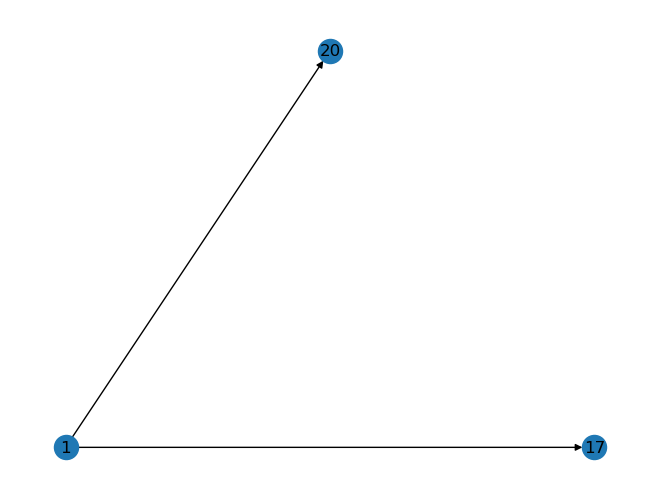

In [4]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]['precedence_relations'], color = 'r')
p_graph.add_edges_from(test_instances[0][1]['precedence_relations'], color= 'k')
colors = [p_graph[u][v]['color'] for u,v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
plt.savefig("precedence_graph.png", format="PNG" )

In [5]:
test_instances[0]

[{'num_tasks': 4,
  'cycle_time': 450,
  'order_strength': 0.268,
  'task_times': {'1': 142, '15': 69, '17': 73, '20': 186},
  'precedence_relations': [('1', '17')],
  'model_no': 0,
  'c_em': 300,
  'max_workers': 3},
 {'num_tasks': 4,
  'cycle_time': 450,
  'order_strength': 0.3,
  'task_times': {'1': 58, '15': 124, '17': 178, '20': 53},
  'precedence_relations': [('1', '17'), ('1', '20')],
  'model_no': 1,
  'c_em': 300,
  'max_workers': 3}]

In [6]:




partitions = []
task_partitioning(partitions, [[] for _ in range(NO_S)], list(all_tasks), NO_S,  test_instances[0][0])

In [7]:
feasible_partitions = {}

for model in models:
    partitions = []
    task_partitioning(partitions, [[] for _ in range(NO_S)], list(all_tasks), NO_S,  test_instances[0][model])
    feasible_partitions[f'model_{model}'] = partitions

In [8]:
feasible_partitions

{'model_0': [[['17', '20', '1'], ['15']],
  [['17', '15', '1'], ['20']],
  [['17', '1'], ['20', '15']],
  [['20', '15', '1'], ['17']],
  [['20', '15'], ['17', '1']],
  [['20', '1'], ['17', '15']],
  [['20'], ['17', '15', '1']],
  [['15', '1'], ['17', '20']],
  [['15'], ['17', '20', '1']],
  [['1'], ['17', '20', '15']]],
 'model_1': [[['17', '20', '1'], ['15']],
  [['17', '15', '1'], ['20']],
  [['17', '1'], ['20', '15']],
  [['20', '15', '1'], ['17']],
  [['20', '1'], ['17', '15']],
  [['15', '1'], ['17', '20']],
  [['15'], ['17', '20', '1']],
  [['1'], ['17', '20', '15']]]}

## MDP State
### State variables
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise

In [9]:
omega

[['0', '0'], ['0', '1'], ['1', '0'], ['1', '1']]

### Defining decision variables
R_osa -- equal to 1 if action a performs task o on the model in station s

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a


### Other parameters
q_as -- number of workers required in station s for action a






## STATE markov decision process

In [10]:
R_osa = LpVariable.dicts('R_osa', (all_tasks, stations, actions), lowBound=0, cat=LpBinary)

In [11]:
no_line_pictures = len(omega)
no_line_pictures

4

In [12]:
omega

[['0', '0'], ['0', '1'], ['1', '0'], ['1', '1']]

In [13]:
feasible_partitions


{'model_0': [[['17', '20', '1'], ['15']],
  [['17', '15', '1'], ['20']],
  [['17', '1'], ['20', '15']],
  [['20', '15', '1'], ['17']],
  [['20', '15'], ['17', '1']],
  [['20', '1'], ['17', '15']],
  [['20'], ['17', '15', '1']],
  [['15', '1'], ['17', '20']],
  [['15'], ['17', '20', '1']],
  [['1'], ['17', '20', '15']]],
 'model_1': [[['17', '20', '1'], ['15']],
  [['17', '15', '1'], ['20']],
  [['17', '1'], ['20', '15']],
  [['20', '15', '1'], ['17']],
  [['20', '1'], ['17', '15']],
  [['15', '1'], ['17', '20']],
  [['15'], ['17', '20', '1']],
  [['1'], ['17', '20', '15']]]}

In [14]:
def create_model_histories(feasible_partitions, models, NO_S):
    model_histories = {}
    for model in models:
            feasible_histories = []
            for index, partition in enumerate(feasible_partitions[f'model_{model}']):
                feasible_history = {}
                feasible_history['index'] = index
                feasible_history['station_0'] = []
                completed_tasks = partition[0]
                for station in range(1,NO_S):
                    feasible_history[f'station_{station}'] = []
                    feasible_history[f'station_{station}'].append(completed_tasks.copy())
                    completed_tasks = completed_tasks + partition[station]
                feasible_histories.append(feasible_history)
            model_histories[f'model_{model}'] = feasible_histories
    return model_histories
model_histories = create_model_histories(feasible_partitions,models, NO_S)

In [15]:
import copy
def create_picture_hist(picture, D, d, d_count, model_histories, current_station, no_s):
    if current_station == no_s:
            d_copy = copy.deepcopy(d)
            d_copy['index'] = d_count
            D.append(d_copy)
            return d_count + 1
    for history in model_histories[f'model_{picture[current_station]}']:
        d_copy = copy.deepcopy(d)
        d_copy[f'model_at_{current_station}'] = picture[current_station]
        d_copy[f'history_at_{current_station}'] = history[f'station_{current_station}']
        d_count = create_picture_hist(picture, D, d_copy, d_count, model_histories, current_station + 1, no_s)
    return d_count
D = []
d_count = 0
for picture in omega:
    picture_hist = []
    d_count = create_picture_hist(picture, picture_hist, {},d_count,  model_histories, 0, NO_S)
    D = D + picture_hist

In [16]:
for d in D:
    action = {}
    for station in range(NO_S):
        

{'model_at_0': '1',
 'history_at_0': [],
 'model_at_1': '1',
 'history_at_1': [['1']],
 'index': 323}